In [ ]:
%pip install catboost

In [113]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, to_graphviz
from lightgbm import LGBMClassifier

## Data Loading

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/TawerV10/churn_prediction/main/datasets/Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Initial Data Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
df.isnull().sum().sum(), df.isna().sum().sum()

(0, 0)

In [10]:
df.duplicated(keep=False).sum()

0

In [11]:
numerical_columns = df.select_dtypes(include=[np.number]).columns.to_list()
categorical_columns = df.select_dtypes(include=[object]).columns.to_list()
numerical_columns, categorical_columns

(['SeniorCitizen', 'tenure', 'MonthlyCharges'],
 ['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'TotalCharges',
  'Churn'])

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [13]:
df.describe(include='object')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


Summary:
- dataset has 7043 samples and 21 features
- no missed data
- no duplicated samples
- SeniorCitizen is a categorical column with values 0 and 1
- customerID has all unique value so it's not categorical
- TotalCharges is a numerical column and has 11 samples with empty value
- Churn: a distribution between No and Yes is 73.46% - 26.54%


## Exploratory Data Analysis



In [14]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

Look for a distribution of numerical columns

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>, <Axes: >]],
      dtype=object)

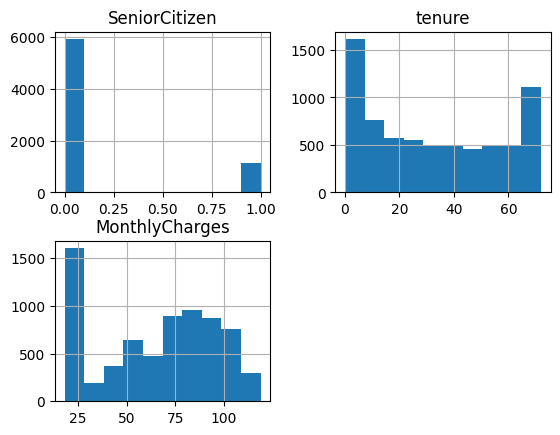

In [15]:
df.hist(numerical_columns)

Look for a distribution of categorical columns

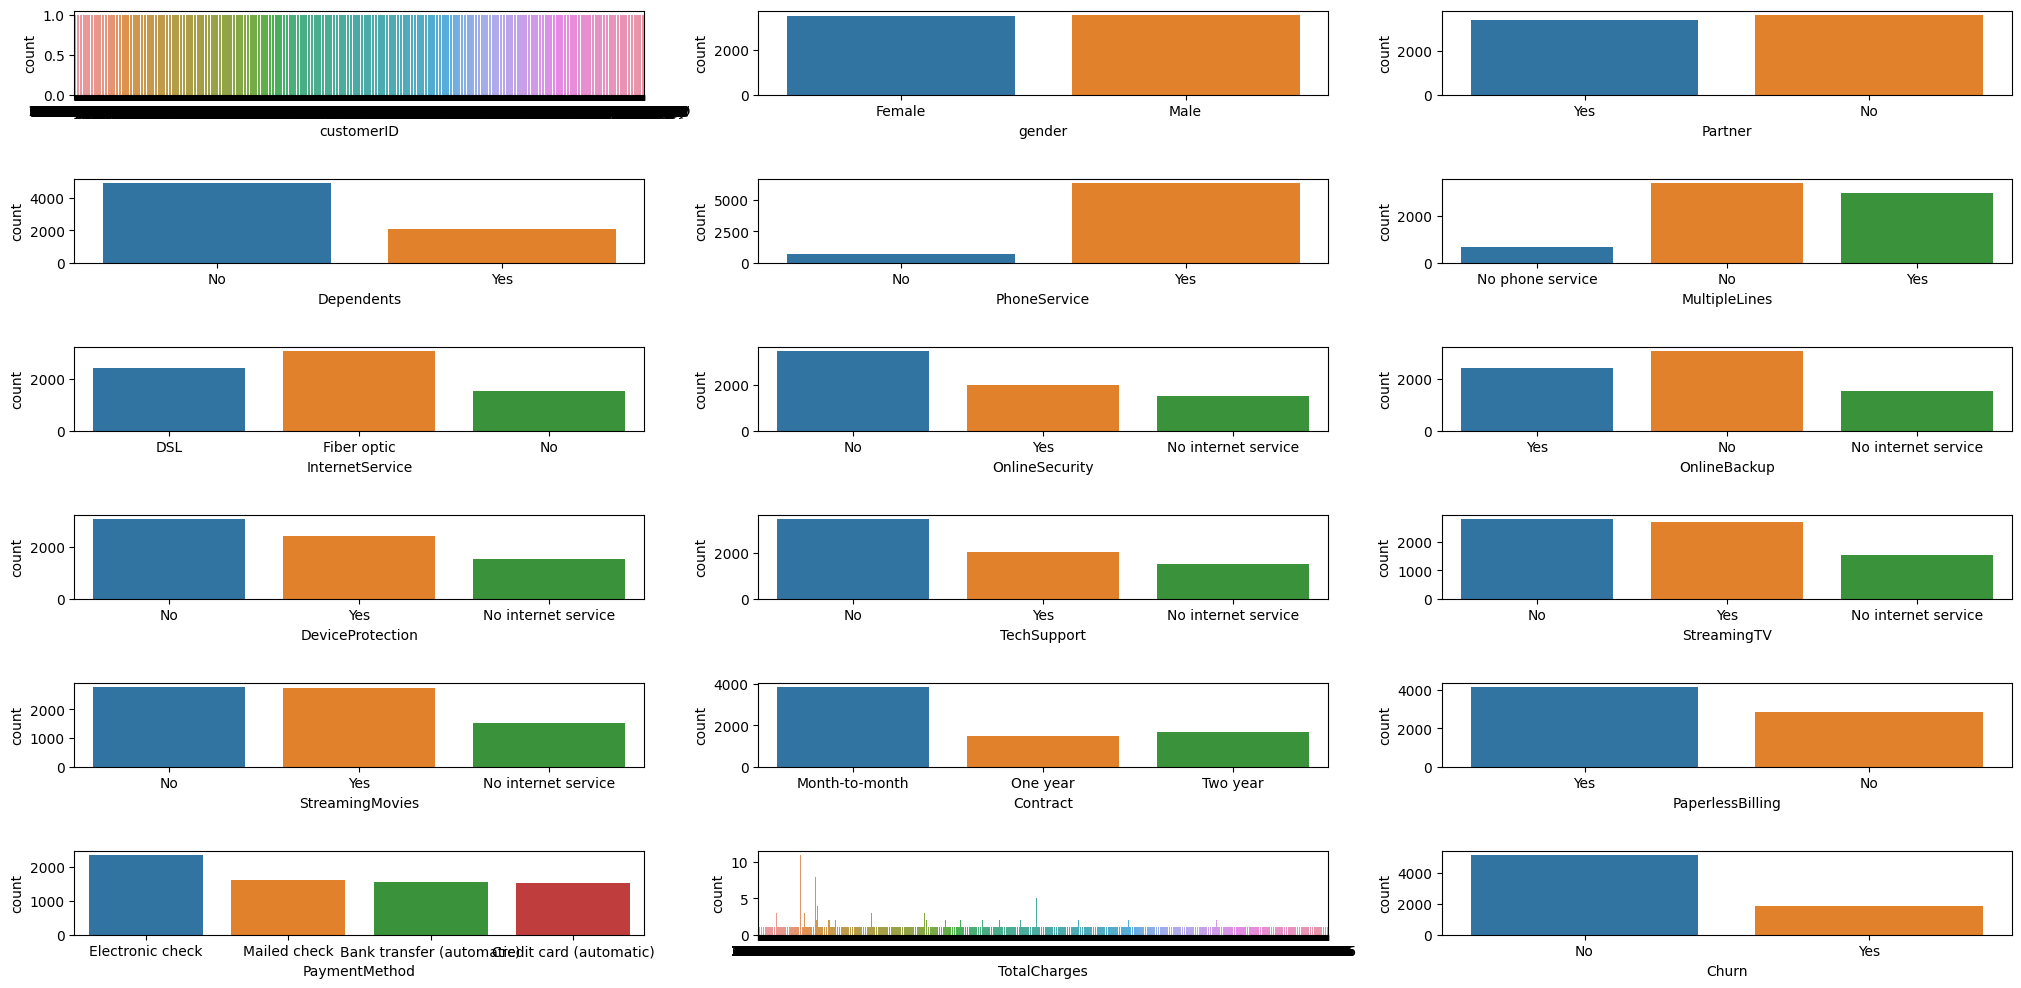

In [16]:
fig, axes = plt.subplots(6, 3, figsize=(25, 12))
for idx, cat_col in enumerate(categorical_columns):
    row, col = idx//3, idx%3
    sns.countplot(x=cat_col, data=df, ax=axes[row, col])
plt.subplots_adjust(hspace=1)

Confirmations based on plots of numerical and categorical features:
- SeniorCitizen is a categorical column (values 0 and 1)
- customerID and TotalCharges are numerical columns
- No internet service and No phone service are not different from No and can be replaced with No

Hadling empty values in TotalCharges

In [17]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df[np.isnan(df['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


We can notice in tensure column the values equal to 0.
Lets check if there are any other rows with 0 in tensure

In [18]:
df[df['tenure'] == 0].index == df[np.isnan(df['TotalCharges'])].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

The indices are the same with the missed data in TotalCharges

So lets delete these rows with unrepresentive data


In [19]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df.shape

(7032, 21)

Also we should drop a customerID column because it isn't useful for prediction a churn

In [20]:
df = df.drop(['customerID'], axis=1)

Converting SeniorCitizen into categorical column

In [21]:
df['SeniorCitizen'].replace({0: "No", 1: "Yes"}, inplace=True)

Modify columns which have No internet/phone service

In [22]:
df['MultipleLines'].replace('No phone service', 'No', inplace=True)
for i in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[i].replace('No internet service', 'No', inplace=True)

Converting Churn in values 0 and 1

In [23]:
df['Churn'].replace({'No': 0, 'Yes': 1}, inplace=True)

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [35]:
df.tenure[df.tenure > 0].value_counts().sum()

7032

In [36]:
df.MonthlyCharges[df.MonthlyCharges > 0].value_counts().sum()

7032

In [37]:
df.TotalCharges[df.TotalCharges > 0].value_counts().sum()

7032

## Visualization

Defining a count of all subgroups in dependence of Gender to Churn

In [ ]:
churn_no = df['Churn'].value_counts()[0]
churn_yes = df['Churn'].value_counts()[1]
churn_no_female = df["Churn"][(df["Churn"] == 0)].groupby(by=df["gender"]).count()[0]
churn_no_male = df["Churn"][df["Churn"] == 0].groupby(by=df["gender"]).count()[1]
churn_yes_female = df["Churn"][df["Churn"]== 1].groupby(by=df["gender"]).count()[0]
churn_yes_male = df["Churn"][df["Churn"]== 1].groupby(by=df["gender"]).count()[1]
(churn_no, churn_yes), (churn_no_female, churn_no_male), (churn_yes_female, churn_yes_male)

((5163, 1869), (2544, 2619), (939, 930))

Plotting Churn-Gender distribution

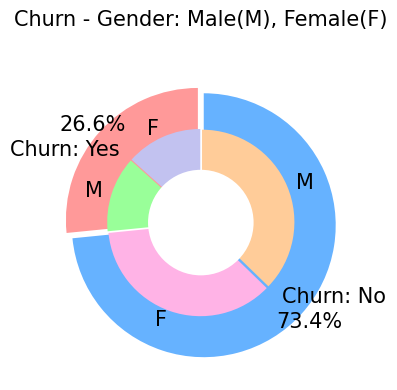

In [ ]:
plt.figure(figsize=(4, 4))

#Plots
plt.pie([churn_yes, churn_no],
        labels=["Churn: Yes", "Churn: No"],
        autopct='%1.1f%%',
        pctdistance=1.08,
        labeldistance=0.8,
        colors=['#ff9999', '#66b2ff'],
        startangle=90,
        frame=True,
        explode=(0.3, 0.3) ,
        radius=10,
        textprops={"fontsize": 15},
        counterclock=True)

plt.pie([churn_yes_female, churn_yes_male, churn_no_female, churn_no_male],
        labels=["F", "M", "F", "M"],
        colors=['#c2c2f0', '#99ff99', '#ffb3e6', '#ffcc99'],
        startangle=90,
        explode=(0.1, 0.1, 0.1, 0.1),
        radius=7,
        textprops={"fontsize": 15},
        counterclock=True)

# Draw white circle
centre_circle = plt.Circle((0,0), 4, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn - Gender: Male(M), Female(F)', fontsize=15, y=1.1)
plt.axis('equal')
plt.tight_layout()
plt.show()

Churn - Categorical columns distribution

In [ ]:
columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

num_columns = 5
num_rows = -(-len(columns) // num_columns)

fig = make_subplots(rows=num_rows, cols=num_columns, subplot_titles=columns)

for i, column in enumerate(columns, start=1):
    subplot_data = px.histogram(df, x="Churn", color=column).update_traces(marker=dict(line=dict(color='black', width=0.5)))
    for trace in subplot_data['data']:
        fig.add_trace(trace, row=(i-1)//num_columns + 1, col=(i-1) % num_columns + 1)

fig.update_layout(showlegend=False, height=250 * num_rows, title_text="<b>Distribution of Churn for Categorical Columns</b>")
fig.show()

Churn - Numerical columns distribution

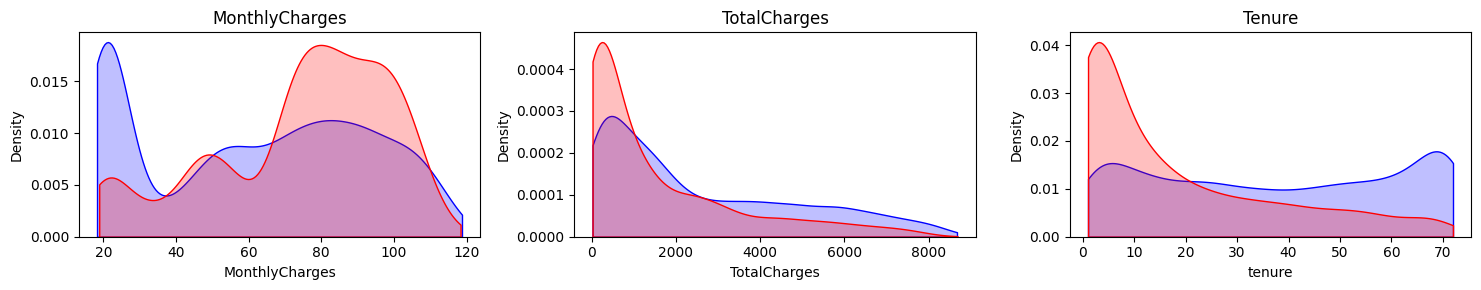

In [ ]:
columns = ['MonthlyCharges', 'TotalCharges', 'tenure']
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 3))

for i, column in enumerate(columns):
    ax = sns.kdeplot(df[column][(df["Churn"] == 0)], color="Blue", fill=True, cut=0, ax=axes[i])
    ax = sns.kdeplot(df[column][(df["Churn"] == 1)], color="Red", fill=True, cut=0, ax=axes[i])
    ax.set_title(f'{column[0].upper()}{column[1:]}')

plt.tight_layout()
plt.show()

Correlation between features

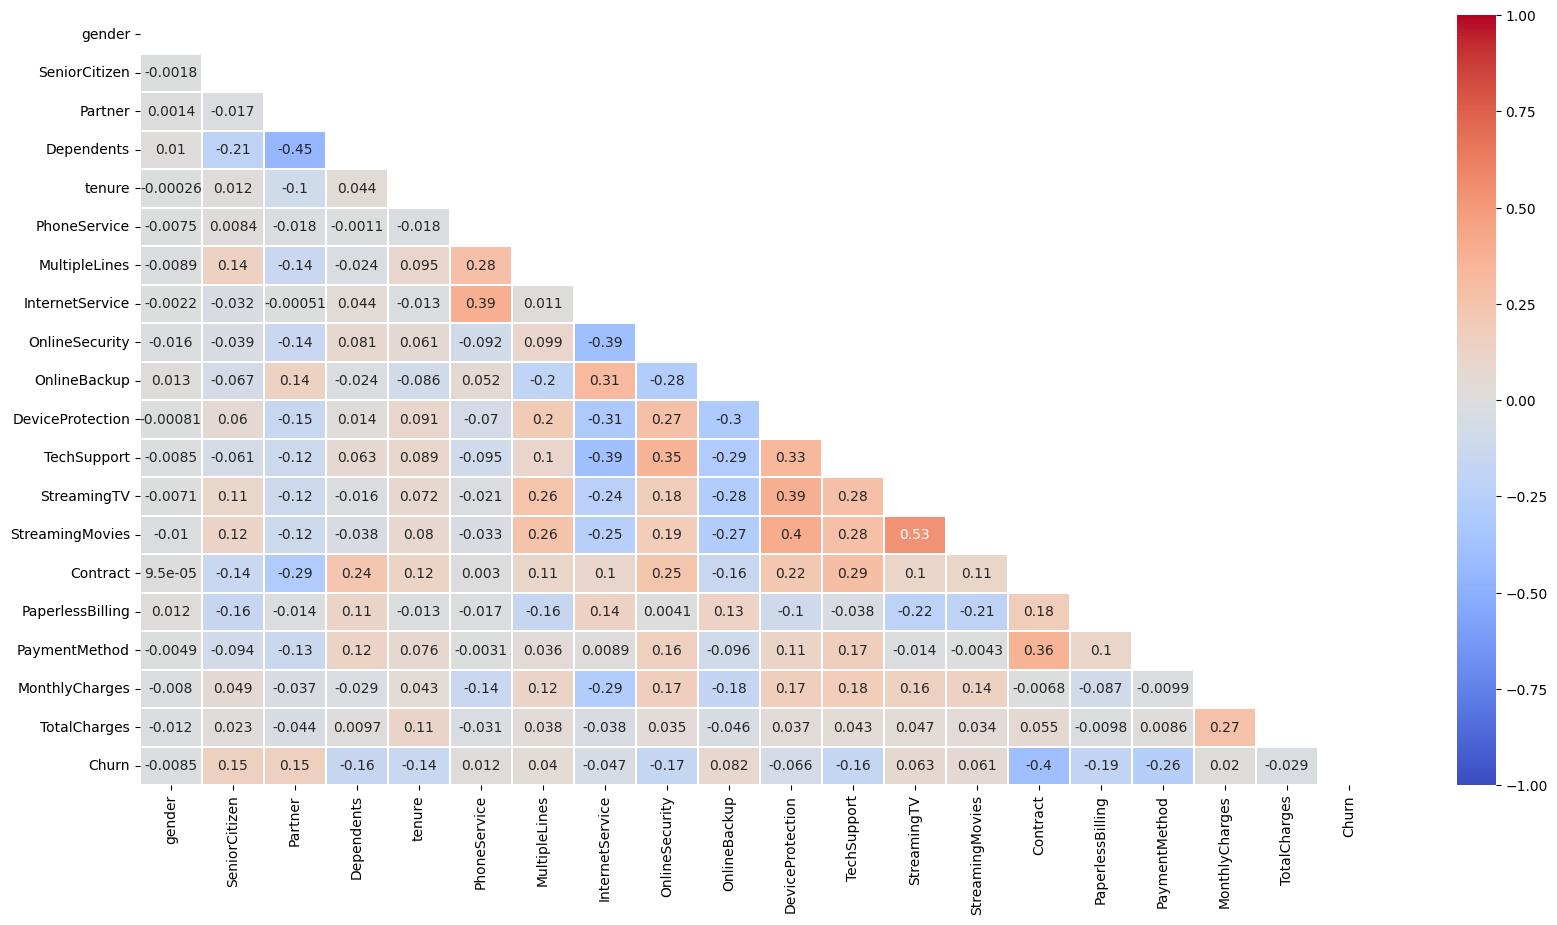

In [ ]:
plt.figure(figsize=(20, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Handling outliers in numerical columns

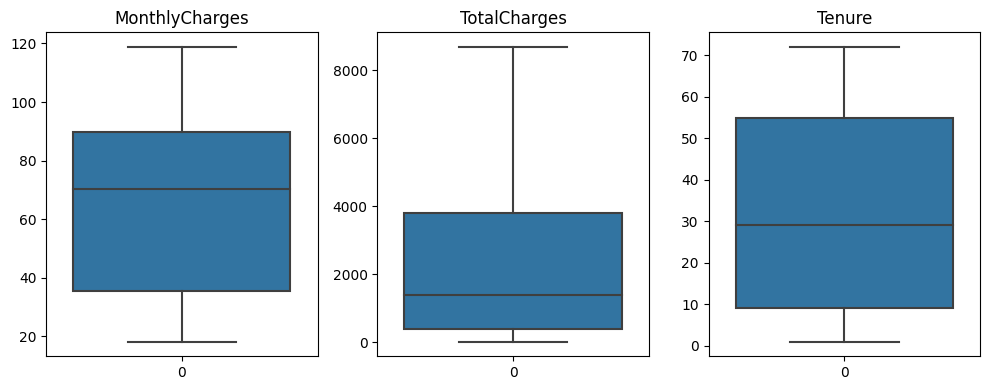

In [ ]:
columns = ['MonthlyCharges', 'TotalCharges', 'tenure']
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(10, 4))

for i, column in enumerate(columns):
    ax = sns.boxplot(df[column], ax=axes[i])
    ax.set_title(f'{column[0].upper()}{column[1:]}')

plt.tight_layout()
plt.show()

In [ ]:
df[['MonthlyCharges', 'TotalCharges', 'tenure']].describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00


## Feature Engineering

In [64]:
X = df.drop(columns=['Churn'])
y = df['Churn']
X.shape, y.shape

((7032, 19), (7032,))

Splitting data to train and test sets

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((5625, 19), (1407, 19))

Defining numerical and categorical columns after EDA

In [66]:
numerical_columns = X.select_dtypes(include=[np.number]).columns.to_list()
categorical_columns = X.select_dtypes(include=[object]).columns.to_list()
numerical_columns, categorical_columns

(['tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

Applying scaler for numerical columns and one hot encoding for categorical

In [67]:
ct = make_column_transformer(
    (MinMaxScaler(), numerical_columns),
    (OneHotEncoder(), categorical_columns)
)

In [68]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)
X_train.shape, X_test.shape

((5625, 39), (1407, 39))

## Model Building

### Building all main ensembles without optimization

In [72]:
names = [
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "GradientBoostingClassifier",
    "HistGradientBoostingClassifier",
    "CatBoostClassifier",
    "XGBClassifier",
    "LGBMClassifier"
]

In [73]:
classifiers = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    CatBoostClassifier(),
    XGBClassifier(),
    LGBMClassifier()
]

In [ ]:
models = []
for name, clf in zip(names, classifiers):
  clf.fit(X_train, y_train)

  models.append([name, clf])

In [ ]:
for name, clf in models:
  pred = clf.predict(X_test)
  print(f'{name} {accuracy_score(y_test, pred)}\n{classification_report(y_test, pred)}')

RandomForestClassifier 0.7761194029850746
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1033
           1       0.60      0.46      0.52       374

    accuracy                           0.78      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.76      0.78      0.77      1407

AdaBoostClassifier 0.7931769722814499
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.78      0.79      0.79      1407

GradientBoostingClassifier 0.7938877043354655
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1033
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1407
  

### Trying to optimize score using GridSearchCV

In [ ]:
grid_params = {
    "RandomForestClassifier": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "AdaBoostClassifier": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5]
    },
    "GradientBoostingClassifier": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7]
    },
    "HistGradientBoostingClassifier": {
        'max_iter': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7]
    },
    "CatBoostClassifier": {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [50, 100, 200]
    },
    "XGBClassifier": {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100, 200]
    },
    "LGBMClassifier": {
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100, 200]
    }
}

In [ ]:
grid_models = []

for name, clf in zip(names, classifiers):
  grid_search = GridSearchCV(estimator=clf, param_grid=grid_params.get(name), cv=5)
  grid_search.fit(X_train, y_train)

  grid_models.append([name, grid_search])

In [ ]:
for name, clf in grid_models:
  pred = clf.predict(X_test)
  print(f'{name} {accuracy_score(y_test, pred)}\n{classification_report(y_test, pred)}')

RandomForestClassifier 0.7981520966595593
AdaBoostClassifier 0.7896233120113717
GradientBoostingClassifier 0.7917555081734187
HistGradientBoostingClassifier 0.7960199004975125
CatBoostClassifier 0.7945984363894811
XGBClassifier 0.7931769722814499
LGBMClassifier 0.7917555081734187


### Dealing with XGBoost

In [ ]:
xgb_clf = XGBClassifier(objective='binary:logistic', early_stopping_rounds=10, seed=42)
xgb_clf.fit(
    X_train,
    y_train,
    verbose=0,
    eval_metric='aucpr',
    eval_set=[(X_test, y_test)]
)

In [93]:
def plot_confusion_matrix(y_test, X_test, clf):
  cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
  disp = ConfusionMatrixDisplay(
      confusion_matrix=cm,
      display_labels=['Didn\'t leave', 'Left']
      )

  disp.plot()
  plt.show()

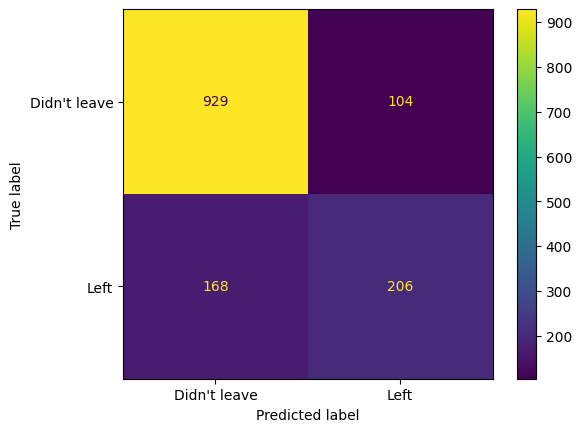

In [94]:
plot_confusion_matrix(y_test, X_test, xgb_clf)

### Optimizing XGBoost with GridSearchCV

In [95]:
params = {
      'max_depth': [3, 5, 7],
      'learning_rate': [0.01, 0.05, 0.1],
      'gamma': [0, 0.25, 1.0],
      'reg_lambda': [0, 1, 10],
      'scale_pos_weight': [1, 3, 5]
}

In [98]:
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        early_stopping_rounds=10,
        subsample=0.9,
        colsample_bytree=0.5,
        seed=42
    ),
    param_grid=params,
    scoring='roc_auc',
    cv=5,
    n_jobs=10,
    verbose=0
)

In [ ]:
grid_xgb.fit(
    X_train,
    y_train,
    verbose=False,
    eval_metric='aucpr',
    eval_set=[(X_test, y_test)]
)

In [100]:
grid_xgb.best_params_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'reg_lambda': 10,
 'scale_pos_weight': 1}

In [101]:
new_params = {
      'max_depth': [3, 4, 5],
      'learning_rate': [0.1, 0.5, 1],
      'gamma': [0, 0.1, 0.25],
      'reg_lambda': [10, 20, 50],
      'scale_pos_weight': [1, 2, 3]
}

new_grid_xgb = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        early_stopping_rounds=10,
        subsample=0.9,
        colsample_bytree=0.5,
        seed=42
    ),
    param_grid=new_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=10,
    verbose=0
)

new_grid_xgb.fit(
    X_train,
    y_train,
    verbose=False,
    eval_metric='aucpr',
    eval_set=[(X_test, y_test)]
)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.1, 0.25],
                         'learning_rate': [0.1, 0.5, 1], 'max_depth': [3, 4, 5],
                         'reg_lambda': [10, 20, 50],
                         'scale_pos_weight': [1, 2, 3]},
             scoring='roc_auc')

In [102]:
new_grid_xgb.best_params_

{'gamma': 0.1,
 'learning_rate': 0.5,
 'max_depth': 4,
 'reg_lambda': 50,
 'scale_pos_weight': 2}

In [111]:
final_xgb = XGBClassifier(
        objective='binary:logistic',
        gamma=0.1,
        learning_rate=0.5,
        max_depth=4,
        reg_lambda=50,
        scale_pos_weight=2,
        early_stopping_rounds=10,
        subsample=0.9,
        colsample_bytree=0.5,
        seed=42
)

final_xgb.fit(
    X_train,
    y_train,
    verbose=0,
    eval_metric='aucpr',
    eval_set=[(X_test, y_test)]
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

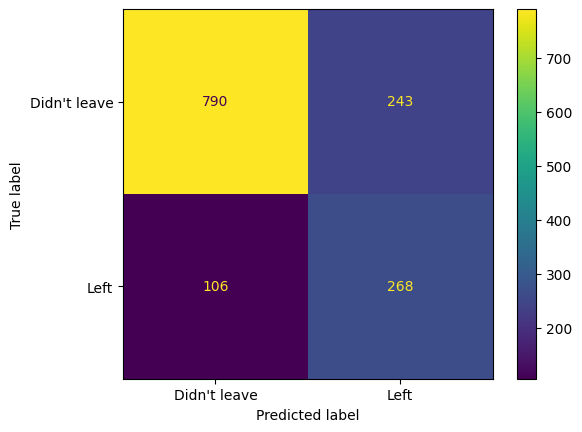

In [112]:
plot_confusion_matrix(y_test, X_test, final_xgb)

### Plotting XGBoost tree

In [117]:
plot_xgb = XGBClassifier(
        objective='binary:logistic',
        gamma=0.1,
        learning_rate=0.5,
        max_depth=4,
        reg_lambda=50,
        scale_pos_weight=2,
        subsample=0.9,
        colsample_bytree=0.5,
        seed=42,
        n_estimators=1
)

plot_xgb.fit(X_train, y_train)

bst = plot_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
  print(f"{importance_type}: {bst.get_score(importance_type=importance_type)}")

weight: {'f0': 5.0, 'f12': 1.0, 'f15': 1.0, 'f16': 2.0, 'f30': 1.0, 'f37': 1.0}
gain: {'f0': 35.8907585144043, 'f12': 20.908605575561523, 'f15': 25.501739501953125, 'f16': 116.5089111328125, 'f30': 1343.0526123046875, 'f37': 0.50982666015625}
cover: {'f0': 273.0890808105469, 'f12': 210.7996063232422, 'f15': 181.31202697753906, 'f16': 775.4501342773438, 'f30': 1550.9002685546875, 'f37': 196.66506958007812}
total_gain: {'f0': 179.45379638671875, 'f12': 20.908605575561523, 'f15': 25.501739501953125, 'f16': 233.017822265625, 'f30': 1343.0526123046875, 'f37': 0.50982666015625}
total_cover: {'f0': 1365.4454345703125, 'f12': 210.7996063232422, 'f15': 181.31202697753906, 'f16': 1550.9002685546875, 'f30': 1550.9002685546875, 'f37': 196.66506958007812}


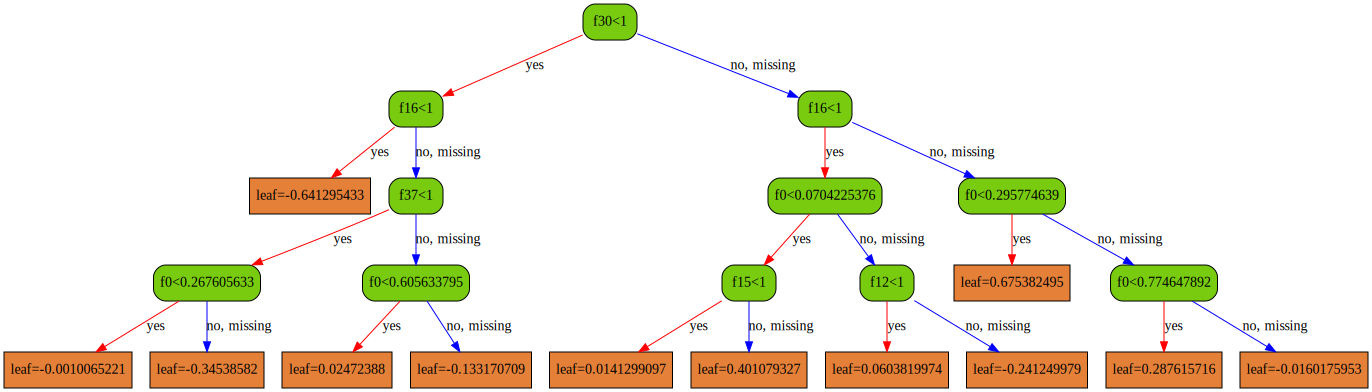

In [118]:
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

to_graphviz(
    plot_xgb,
    num_trees=0,
    size="10x10",
    condition_node_params=node_params,
    leaf_node_params=leaf_params
)